In [1]:
# Imports
import sys
sys.path.append('../python/')
import NGC5533_functions as nf
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import dataPython as dp
import astropy.units as u
import astropy.constants as c

In [2]:
# Importing data
#SPARC is a database of 175 late-type galaxies (spirals and irregulars) with Spitzer photometry 
#at 3.6 mu (tracing the stellar mass distribution) and high-quality HI+Halpha rotation curves 
#(tracing the gravitational potential out to large radii).
#http://astroweb.cwru.edu/SPARC/

data = dp.getXYdata_wYerr('UGC2953.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
#v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#Express as weights
weighdata = 1/(np.sqrt(v_err1**2))

In [3]:
# Parameters from "The stellar mass distributions in early-type disk galaxies"

D = 15.1 * u.Mpc             # distance (Mpc)
i = 49*(np.pi/180)           # inclination angle

# bulge
n = 3.3                      # concentration parameter
re_arcsec = 24.1 * u.arcsec  # effective radius (arcsec)
re_Mpc = (re_arcsec.to(u.degree)/(360 * u.degree)) * 2 * np.pi * D
re_kpc = re_Mpc.to(u.kpc)
print("Effective radius (re): {}.".format(re_kpc))
re = 1.76                    # effective radius (kpc)  
q = 0.6                      # intrinsic axis ratio
      
# disk
h = 4.1                      # disk scalelength (kpc)

Effective radius (re): 1.7642854669257122 kpc.


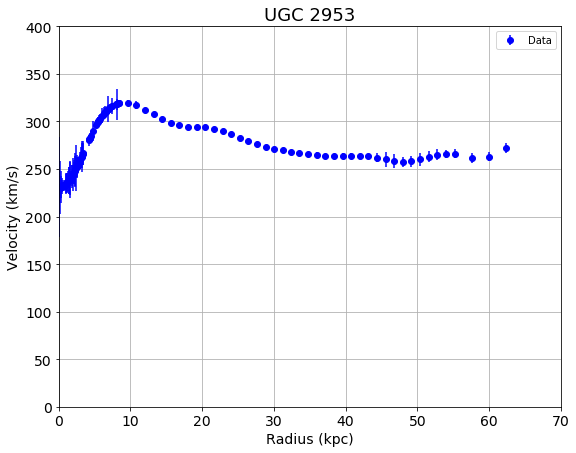

In [4]:
# Plotting Rotational Velocities

fig = plt.figure(figsize=(9,7))

ax = plt.axes()
ax.grid(True)

plt.xlim(0,70)
plt.ylim(0,400)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')

ax.set_title('UGC 2953', fontsize=18)             
ax.set_xlabel('Radius (kpc)', fontsize=14)
ax.set_ylabel('Velocity (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.legend()
plt.show()

In [5]:
# Fitting
# Function for fitting only prefactors + halo's parameters + data thief
def f(r,M,rc,rho00,c,n,re,pref,gpref):
    return np.sqrt(nf.bh_v(r,M,path='../fitting')**2 
                   + nf.h_v(r,rc,rho00,path='../fitting')**2 
                   + c**2 * nf.b_v(r,n=n,re=re,path='../fitting')**2 
                   + pref**2 * nf.d_thief(r)**2
                   + gpref**2 * nf.g_thief(r)**2)

In [6]:
# Fit

#Setup
f_mod = lm.Model(f)
f_params = f_mod.make_params()

#Black Hole
f_params.add('M', value=nf.Mbh_def, min=1.0e8)     #Mass

#Halo
f_params.add('rc', value=nf.h_rc, min=0.1)         #Core Radius
f_params.add('rho00', value=nf.hrho00_c, min=0)    #Density

#Bulge
f_params.add('c', value=1,min=0,max=100)           #Prefactor
f_params.add('n', value=n,min=0,max=100)           #Concentration parameter
f_params.add('re', value=re,min=0,max=100)         #Effective radius

#Disk
f_params.add('pref', value=1,min=0, max=100)       #Prefactor

#Gas
f_params.add('gpref', value=1,min=.8, max=1.2)     #Prefactor

#Do fit
f_fit = f_mod.fit(v_dat,f_params,r=r_dat,weights=weighdata)

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: Inte

In [7]:
print('Fit information:')
f_fit

Fit information:


In [8]:
bestf = f_fit.best_fit

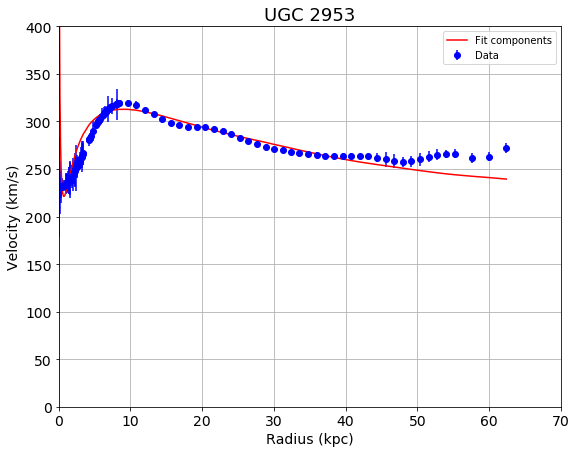

In [9]:
# Plot
fig = plt.figure(figsize=(9,7))

ax = plt.axes()
ax.grid(True)

plt.xlim(0,70)
plt.ylim(0,400)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,bestf,'r-',label='Fit components')

ax.set_title('UGC 2953', fontsize=18)             
ax.set_xlabel('Radius (kpc)', fontsize=14)
ax.set_ylabel('Velocity (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.legend()
plt.show()